In [1]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [2]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

In [3]:
# Boundary condition 
coefii = 1000

X_0 = 0  #del
Y_0 = 0     #w
X_0_v = -1/coefii
Y_0_v = 383.9911/coefii

In [4]:
# Differential equation parameters
ws = 376.9911

# ws = 0.376
# coefii = ws/4
K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii

def F_E1(X_prime, X,Y_prime,Y, t):       # DE, works with numpy arrays
    return (X_prime+ws-Y)
    # return X_prime+ws-Y 

def F_E2(X_prime, X,Y_prime,Y, t):       # DE, works with numpy arrays
    # return Y_prime
    return Y_prime-K1+K2*np.sin(coefii*X)+K3*(-ws+Y)*coefii

In [5]:
# Differential equation's exact solution - for comparison
def X_t(t):
    # return X_0_v*np.cos(t)+(3*X_0_v+2*Y_0_v)*np.sin(t)
    return 0

def Y_t(t):
    return 0

In [6]:
t=np.random.uniform(0,1,size=50,requires_grad=False)

In [7]:
# define embedding layer
def embedding(x,wires):
    qml.RY(x, wires=wires[1])

In [8]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

In [9]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubit 1
    qml.RY(theta,wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

In [10]:
@qml.qnode(dev, diff_method="backprop", interface="autograd")
def quantum_net(theta,x):
    
    # encode data
    embedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    # return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))
    return qml.expval(qml.PauliZ(0))

In [11]:
num_layers=4
theta1=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
theta2=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta = np.load('my_theta1.npy')
print(qml.draw(quantum_net)(theta1,0))

0: ──H────────────────╭●──H──────╭●──H──────╭●──H──────╭●──H─┤  <Z>
1: ──RY(0.00)──RY(M0)─╰X──RY(M1)─╰X──RY(M2)─╰X──RY(M3)─╰X────┤     


In [12]:
# add the classical layer   #TODO
def classical_quantum_net(theta,w,t):
    r1=quantum_net(theta,t)[0]
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[0]+w[1]*r1+w[2]*r1**2
    # r1=quantum_net(theta,x)
    return r1

In [13]:
def classical_quantum_net_prime(theta,w,t):
    r1=quantum_net(theta,t)[0]
    r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[1]*r1_prime+2*w[2]*r1_prime*r1


In [14]:
# def square_loss(labels,predictions):
#     loss=0
#     for l,p in zip(labels,predictions):
#         loss=loss+(l-p)**2
#     loss=loss/len(labels)
#     return loss

In [15]:
# #loss boundary
# def loss_b(U_predict):
    
    

In [16]:

def cost(theta1,theta2,w1,w2,t):

    # loss inner points
    loss_i = 0

    X_t_pred = np.array([classical_quantum_net(theta=theta1,w=w1,t=point) for point in t])
    X_t_prime = np.array([classical_quantum_net_prime(theta=theta1,w=w1,t=point) for point in t])
    
    Y_t_pred = np.array([classical_quantum_net(theta=theta2,w=w2,t=point) for point in t])
    Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])

    loss_i += np.mean(F_E1(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)
    loss_i += np.mean(F_E2(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)

    # loss boundary points
    loss_b = 0
    X_0_pred = classical_quantum_net(theta1,w1,0)
    Y_0_pred = classical_quantum_net(theta2,w2,0)

    # print(U_0)
    loss_b += (X_0_v-X_0_pred)**2+(Y_0_v-Y_0_pred)**2
    return 0.2*loss_b + 0.8*loss_i
    # return loss_i

In [17]:
w1=np.zeros(3,requires_grad=True)
w2=np.zeros(3,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [18]:
start=now()
print(start)

2023-08-01 23:33:51.266628


In [19]:
epochs=100
cost_max = 10000
theta1_best = None
theta2_best = None
w1_best = None
w2_best = None
for e in range(1,epochs+1):
    (theta1,theta2,w1,w2,_),_cost=opt.step_and_cost(cost,theta1,theta2,w1,w2,t)
    if _cost<cost_max:
        cost_max = _cost
        theta1_best = theta1
        theta2_best = theta2
        w1_best = w1
        w2_best = w2
    # (theta,_),_cost=opt.step_and_cost(cost,theta,t)
    if e==1 or e%1==0:
        print(f'Epoch: {e} | Cost: {_cost}')

Epoch: 1 | Cost: 0.4769216767951436
Epoch: 2 | Cost: 0.31075144518172465
Epoch: 3 | Cost: 0.17493310166728446
Epoch: 4 | Cost: 0.07278151548980642
Epoch: 5 | Cost: 0.03358367188844365
Epoch: 6 | Cost: 0.07549966192641872
Epoch: 7 | Cost: 0.12430751727733842
Epoch: 8 | Cost: 0.1307745490372273
Epoch: 9 | Cost: 0.10733092402585667
Epoch: 10 | Cost: 0.07717213604034662
Epoch: 11 | Cost: 0.06472283343100164
Epoch: 12 | Cost: 0.06417136623101809
Epoch: 13 | Cost: 0.07104152778977499
Epoch: 14 | Cost: 0.083475967331729
Epoch: 15 | Cost: 0.0953279064785159
Epoch: 16 | Cost: 0.10253305393713337
Epoch: 17 | Cost: 0.10750131972084545
Epoch: 18 | Cost: 0.11206173681693762
Epoch: 19 | Cost: 0.11321455670514899
Epoch: 20 | Cost: 0.11296645152550763
Epoch: 21 | Cost: 0.11122140292400641
Epoch: 22 | Cost: 0.10908829189972429
Epoch: 23 | Cost: 0.10606031365754609
Epoch: 24 | Cost: 0.10297878414545686
Epoch: 25 | Cost: 0.09978258704836522
Epoch: 26 | Cost: 0.09681887274104548
Epoch: 27 | Cost: 0.093963

In [20]:
# print(_cost)
t=np.random.uniform(0,1,size=50,requires_grad=False)
pred_train_X=np.array([classical_quantum_net(theta1,w1,t) for t in t])
pred_train_Y=np.array([classical_quantum_net(theta2,w2,t) for t in t])

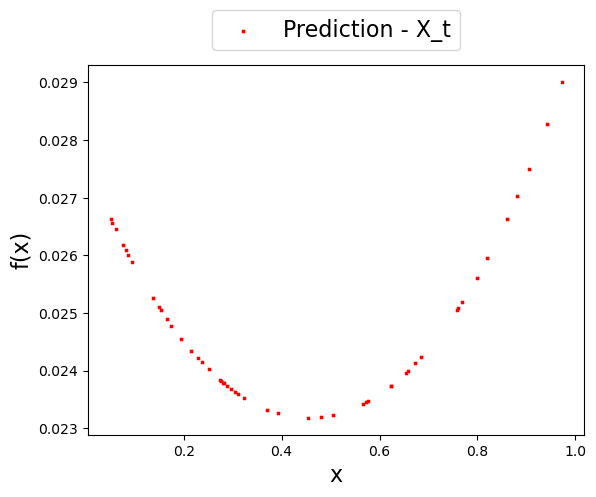

In [24]:
plt.figure()
# plt.scatter(t,X_t(t),facecolors='none', edgecolors='r', label='True - X_t')
plt.scatter(t,pred_train_X, color='red',marker="x",s=4,label='Prediction - X_t')
# plt.scatter(t,Y_t(t),facecolors='none', edgecolors='g', label='True - Y_t')
plt.scatter(t,pred_train_Y, color='green',marker="x",s=4,label='Prediction - Y_t')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
# plt.savefig('1_measurement2_train.png')
plt.show()